## 任务1 基于机器学习的文本分类

### 获取数据集/数据输入


###  特征提取（将特征数字化）


#### 1.词袋特征（Bag-of-word）

词袋模型即把句子拆解成一个一个单词【注意是一个一个的单词】，存在于句子的单词 (不区分大小写)，则对应的向量位置上的数字为1，反之为0，通过这种方式，可以把一个句子变成一个由数字表示的0-1向量。

- 优点：将文本转换为数字的方式非常简单
- 缺点：不考虑词序 只在乎单词是否出现

eg: 单词：[i, you, him, her, love, hate, but]

句子A：I love you

向量a：[1,1,0,0,1,0,0]

#### 2.N元特征 （N-gram）

N元特征与词袋模型最大的不同就是，词袋模型仅考虑了单词存在与否，而N元特征考虑了词组存在与否。例如，当N=2时，I love you 不再看作是 I, love, you 这三个单词，而是 I love, love you 这两个词组。

一般，使用N元特征时，会一并使用1, 2, …, N-1元特征。


eg：特征（N=1&2）：

[i, you, him, her, love, hate, but, i-love, i-hate, love-you, hate-you, you-but, but-love, but-hate, love-him, hate-him]

句子A：I love you

向量a：[1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0]

- 优点：考虑了词序
- 缺点：这种转换方式较为复杂，但是考虑了句子中的词序。还有需要值得注意的是，即使是N=2时，也会产生一些几乎不具有真实语义的词组，比如C中的you-but，它在现实场景中没有具体的语义，但是这些无意义的词组也有可能在分类中起到很关键的作用。

另一方面，随着N的递增，文本的特征数也会上涨，因此遇到数据量大的输入时，较大的N会导致结果模型训练极度缓慢。

### softmax

In [23]:
import torch
X=torch.tensor([[1,2,3],[4,5,6]])
'''
keepdim 表示是否需要保持输出的维度与输入一样，keepdim=True表示输出和输入的维度一样，keepdim=False表示输出的维度被压缩了，也就是输出会比输入低一个维度。
'''
X.sum(0,keepdim=True) # 列相加
X.sum(1,keepdim=True) # 行相加

X=torch.normal(0,1,(2,5))
x_exp=torch.exp(X)
x_exp  # 变为非负的
partition=x_exp.sum(1,keepdim=True) # 按行相加 得出分母
result=x_exp/partition # 分子/分母得到何为1的概率值
result

tensor([[0.1196, 0.1353, 0.2022, 0.4832, 0.0597],
        [0.0371, 0.1937, 0.4221, 0.3061, 0.0411]])

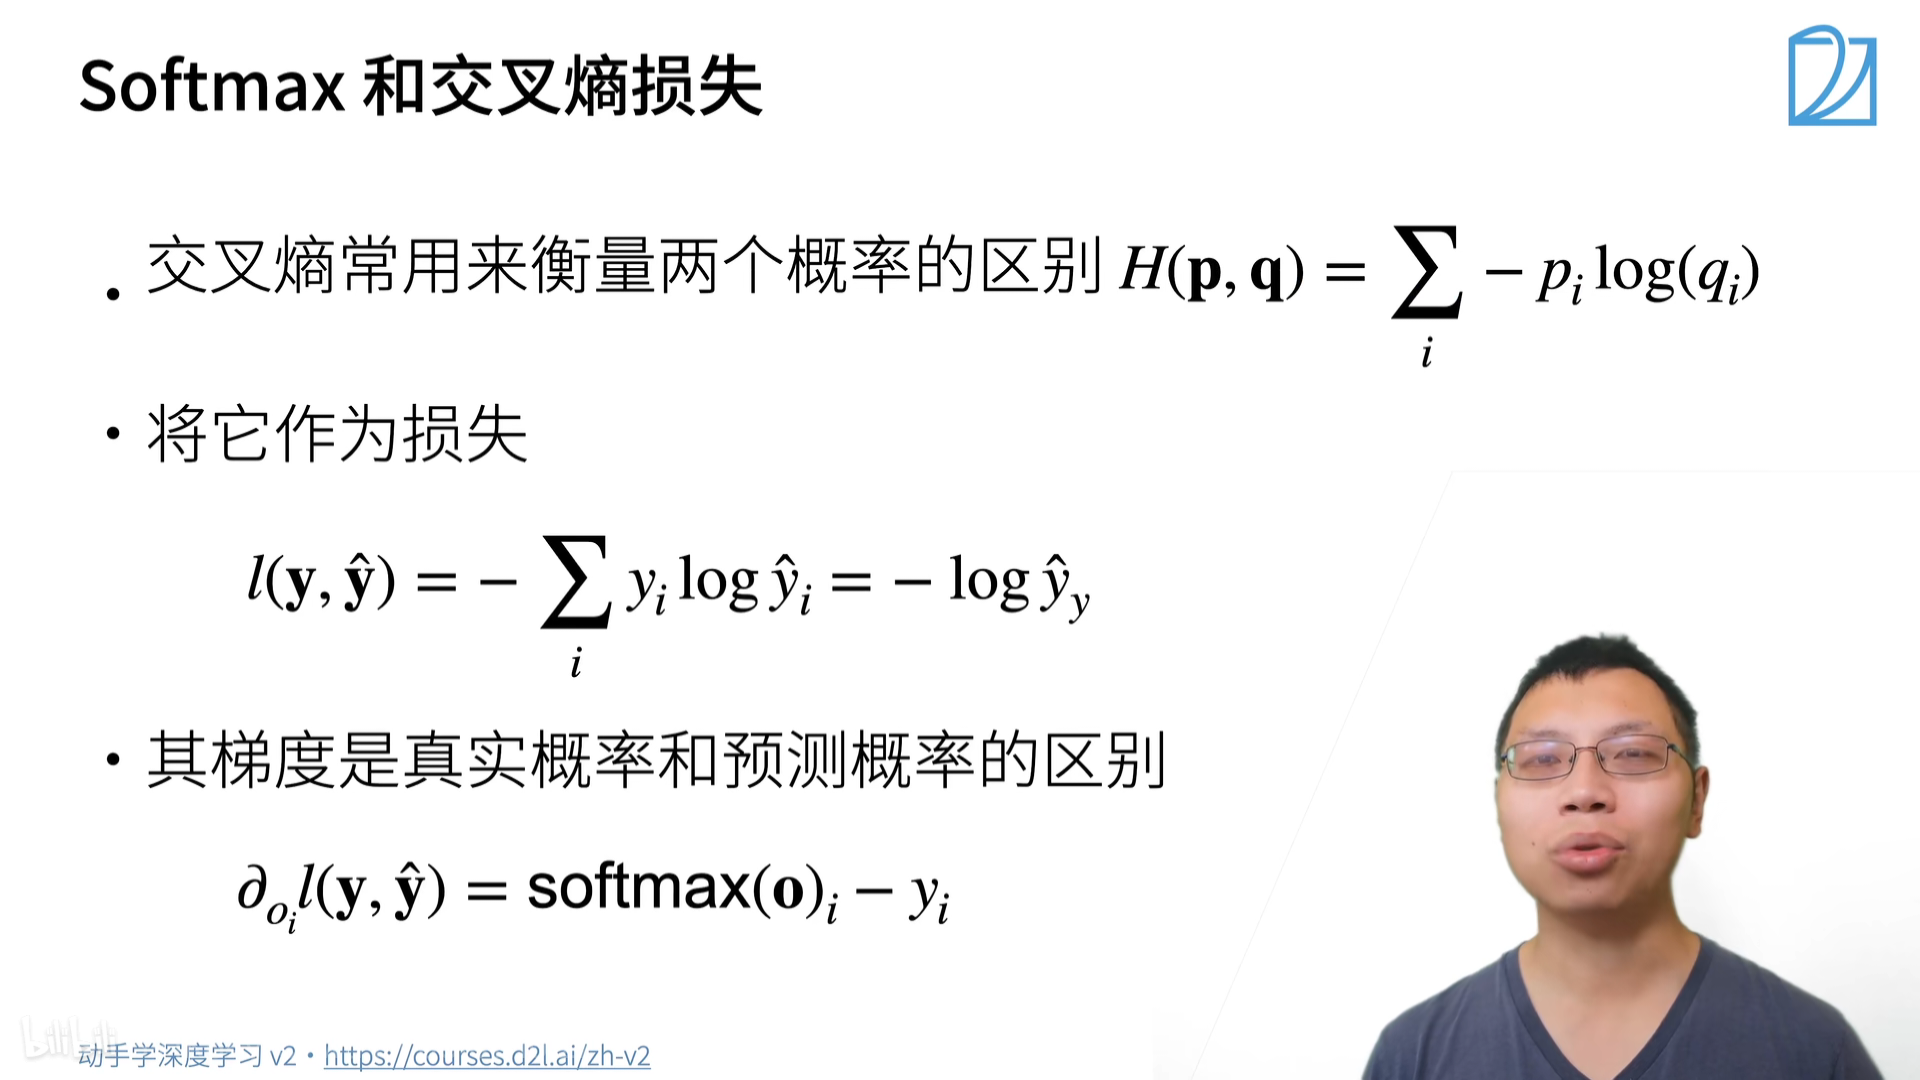
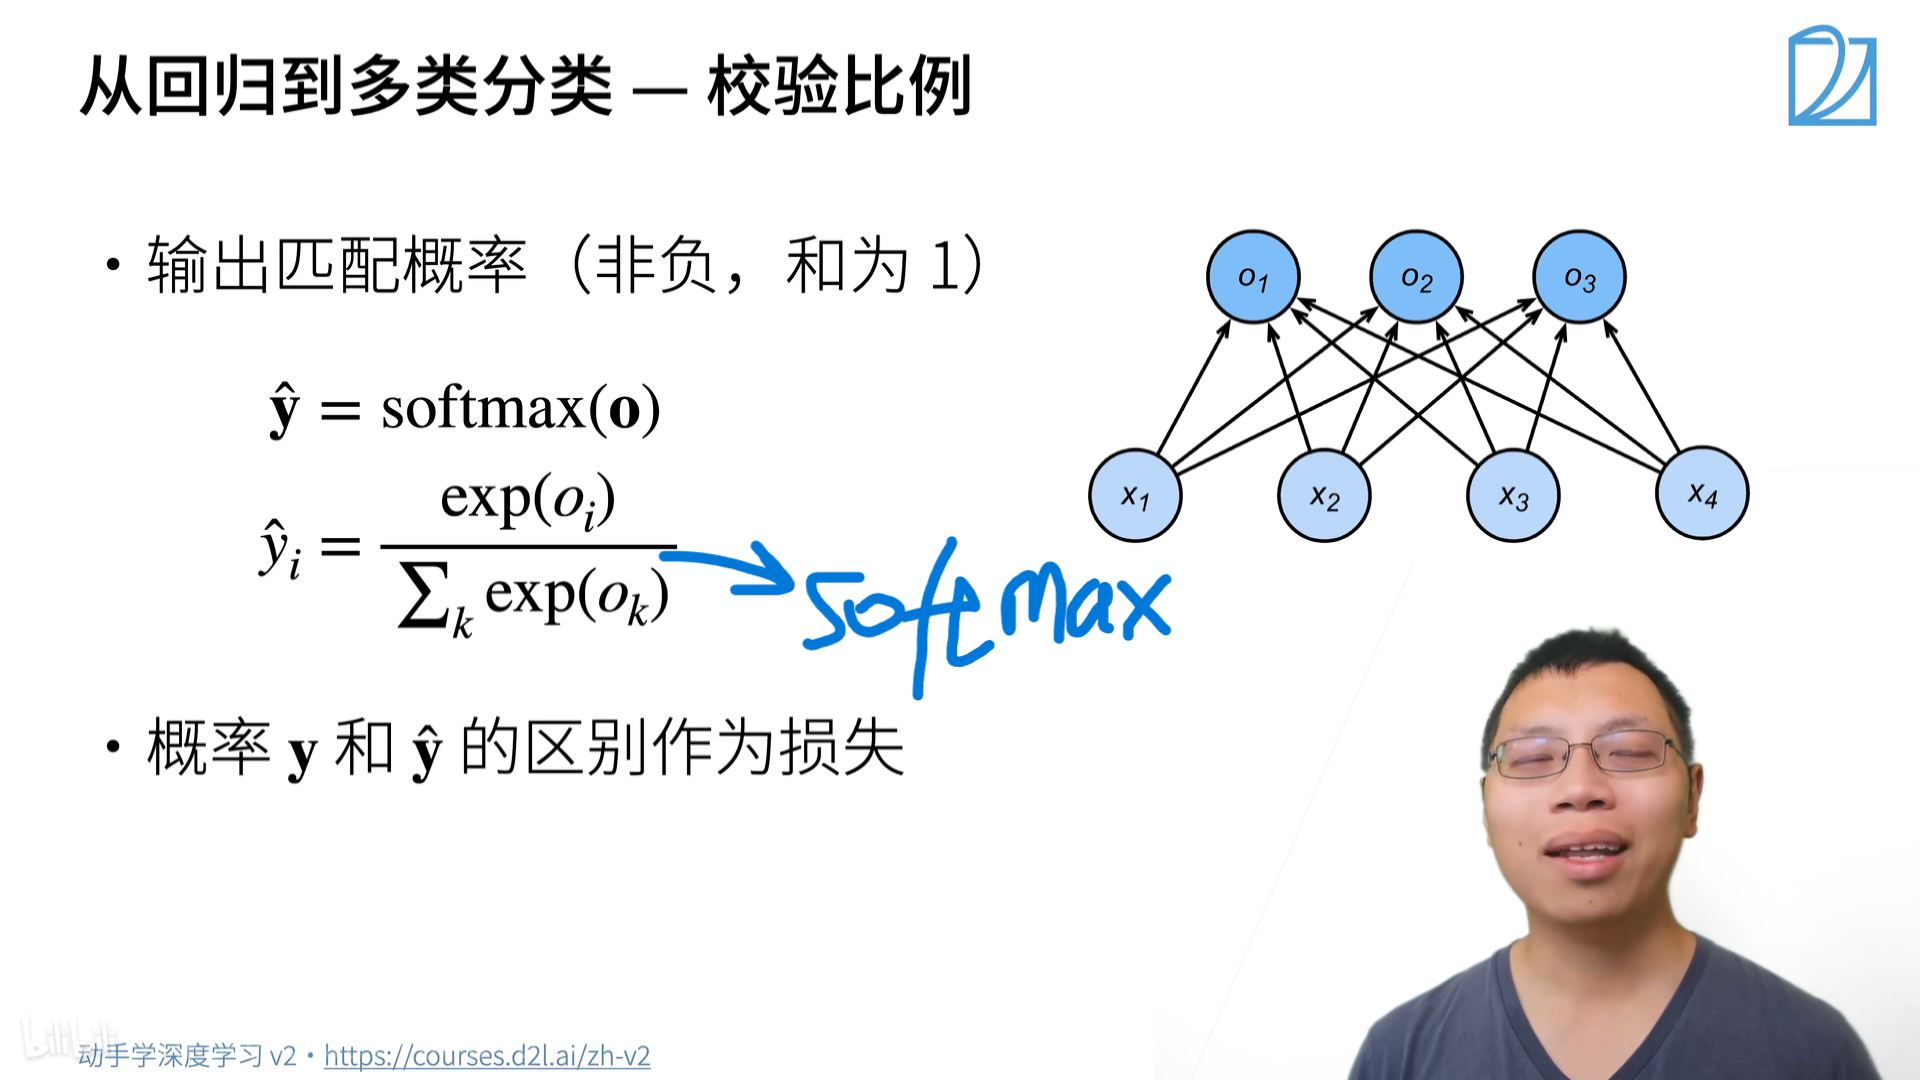

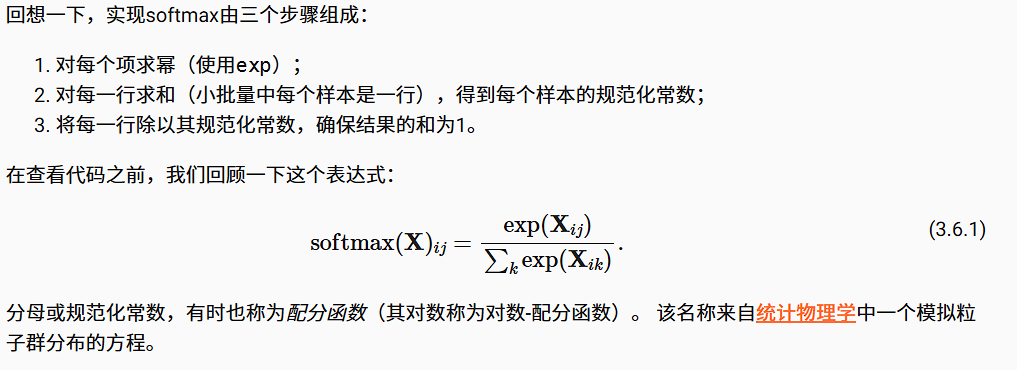

In [28]:
# eg:
X=torch.normal(0,1,(2,5))  # 这是两个样本  分为5类的各自的数值  均值为0 方差为1
print(f"原数据：{X}")

def softmax(x):
    x_exp=torch.exp(x) # 指数变换
    partition=x_exp.sum(1,keepdim=True) # 按行相加
    return x_exp/partition
    
X_prob=softmax(X)
print(f"softmax处理后的数据：{X_prob}")  # 每行元素概率和为1

原数据：tensor([[ 0.9234, -1.3035, -0.6685, -0.7187, -0.8056],
        [-1.6826,  1.2013, -0.2358,  0.1352, -0.3853]])
softmax处理后的数据：tensor([[0.5944, 0.0641, 0.1210, 0.1151, 0.1055],
        [0.0303, 0.5428, 0.1290, 0.1869, 0.1111]])


In [31]:
# 取出真实类别对应的 预测概率
# eg：有三类
y=torch.tensor([0,2])  # 分别对应第1类 和第三类
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]]) # 取出第1类 和第三类对应的概率值
y_hat[[0,1],y]

# 归纳成下述代码：
# y_hat[range(len(y_hat)),y]

tensor([0.1000, 0.5000])

In [41]:
# 交叉熵损失函数
def cross_entropy(y_hat,y):
    # 虽然是log 但实际计算是以e为底的对数
    return -torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [73]:
# 分类问题评估标准
# 将预测值和真实值y 进行比较
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        # 取出每一列最大的概率值
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y   # 数据类型转换 避免因为不兼容 计算出错
    return float(cmp.type(y.dtype).sum())

accuracy_rate=accuracy(y_hat,y)
print(f"准确率为：{accuracy_rate/len(y)}")
        

准确率为：0.5


In [72]:
# 这是上述代码的注意详细分解步骤

# len(y_hat.shape)  # 拿到的是行 2
# y_hat.shape[1]  # 拿到的是列 3
# y_hat = y_hat.argmax(axis=1) # 取出最大概率值 对应的索引值/类别/label  tensor([2, 2])

y  # tensor([0, 2])

y_hat  # tensor([2, 2])


y_hat.type(y.dtype) # 转为一个数据类型

cmp = y_hat.type(y.dtype)==y   #tensor([False,  True]) 只有一个样本的分类是True

float(cmp.type(y.dtype).sum())

1.0

## softmax回归的从零开始实现

In [504]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载 Fashion MNIST 数据集
train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                      download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                      download=True, transform=transform)
# 减少 batch_size 和 num_workers
batch_size = 256
num_workers = 0

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=num_workers)
# 遍历数据加载器
# for data, target in train_loader:
#     print(data, target)

In [505]:
# import torch
# from d2l import torch as d2l

# batch_size = 32
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
# train_iter

这里的每个样本都将用固定长度的向量表示。 原始数据集中的每个样本都是28*28的图像。 

通过展平每个图像，把它们看作长度为784的向量。 

在后面的学习中，再讨论利用图像空间结构的特征， 但现在暂时只把每个像素位置看作一个特征。

在softmax回归中，我们的输出与类别一样多。 因为我们的数据集有10个类别，所以网络输出维度为10。 因此，权重将构成一个
784 * 10的矩阵， 偏置将构成一个1 * 10的行向量。 与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始化为0。

### 初始化模型参数

In [506]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


### 定义softmax操作

In [507]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

### 定义模型

In [508]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 定义损失函数

In [509]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])


### 分类评估指标--准确率

In [510]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        
    cmp = y_hat == y
    return float(cmp.sum())

这里定义一个实用程序类Accumulator，用于对多个变量进行累加。 在上面的evaluate_accuracy函数中， 我们在Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量。 当我们遍历数据集时，两者都将随着时间的推移而累加。

同样，对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。

In [511]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [512]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
        
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y) # --->  def cross_entropy(y_hat, y):
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad() # 梯度清0
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类Animator， 它能够简化本书其余部分的代码。

In [513]:
# from IPython import display
# class Animator:  #@save
#     """在动画中绘制数据"""
#     def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
#                  ylim=None, xscale='linear', yscale='linear',
#                  fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
#                  figsize=(3.5, 2.5)):
#         # 增量地绘制多条线
#         if legend is None:
#             legend = []
#         d2l.use_svg_display()
#         self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
#         if nrows * ncols == 1:
#             self.axes = [self.axes, ]
#         # 使用lambda函数捕获参数
#         self.config_axes = lambda: d2l.set_axes(
#             self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
#         self.X, self.Y, self.fmts = None, None, fmts

#     def add(self, x, y):
#         # 向图表中添加多个数据点
#         if not hasattr(y, "__len__"):
#             y = [y]
#         n = len(y)
#         if not hasattr(x, "__len__"):
#             x = [x] * n
#         if not self.X:
#             self.X = [[] for _ in range(n)]
#         if not self.Y:
#             self.Y = [[] for _ in range(n)]
#         for i, (a, b) in enumerate(zip(x, y)):
#             if a is not None and b is not None:
#                 self.X[i].append(a)
#                 self.Y[i].append(b)
#         self.axes[0].cla()
#         for x, y, fmt in zip(self.X, self.Y, self.fmts):
#             self.axes[0].plot(x, y, fmt)
#         self.config_axes()
#         display.display(self.fig)
#         display.clear_output(wait=True)

这里定义一个实用程序类Accumulator，用于对多个变量进行累加。 在上面的evaluate_accuracy函数中， 我们在Accumulator实例中创建了2个变量， 分别用于存储正确预测的数量和预测的总数量。 当我们遍历数据集时，两者都将随着时间的推移而累加。

In [514]:
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [515]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    # animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
    #                     legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        print(f"训练损失:{train_metrics[0]},训练精度:{train_metrics[1]}")
        test_acc = evaluate_accuracy(net, test_iter)
        print(f"eval精度:{test_acc}")
        # animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
    

### 定义优化函数

In [516]:
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
        
        # print(f"each epoch's W is：{param[0]}")
        # print(f"each epoch's b is：{param[1]}")
        # print(f"**********************************************")

In [517]:
lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

In [518]:
# 开始训练

num_epochs = 10
# print(updater) # 把函数传入了
train_ch3(net, train_loader, test_loader, cross_entropy, num_epochs, updater)

训练损失:0.6809343417485555,训练精度:0.7606833333333334
eval精度:0.7952
训练损失:0.49465899098714194,训练精度:0.8257333333333333
eval精度:0.816
训练损失:0.4680136651357015,训练精度:0.8354833333333334
eval精度:0.8136
训练损失:0.45211046663920085,训练精度:0.8411333333333333
eval精度:0.8205
训练损失:0.44259721552530923,训练精度:0.8448166666666667
eval精度:0.8134
训练损失:0.43556328093210855,训练精度:0.8475666666666667
eval精度:0.8184
训练损失:0.4313986567179362,训练精度:0.8495833333333334
eval精度:0.8369
训练损失:0.4285872124354045,训练精度:0.8503166666666667
eval精度:0.8175
训练损失:0.4211665501912435,训练精度:0.8529
eval精度:0.8184
训练损失:0.4211814927419027,训练精度:0.8532166666666666
eval精度:0.8193


In [520]:
b  # finall result 

tensor([ 0.0094,  0.0126,  0.0039, -0.0110, -0.0232, -0.0668,  0.0091, -0.0517,
         0.1269, -0.0093], requires_grad=True)

### 预测

In [532]:
test_acc=[]
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签"""
    for X, y in test_iter:
        y_hat = net(X)
        y_hat = y_hat.argmax(axis=1)
        # print(f"predict_category: {y_hat}, real_category: {y}")
        test_acc.append((y_hat==y).sum()/len(X))
        print(f"{(y_hat==y).sum()/len(X)}")
    print(sum(test_acc)/len(test_acc)) # tensor(0.8177) 
predict_ch3(net, test_loader)

0.84375
0.84375
0.7734375
0.83984375
0.8203125
0.83984375
0.828125
0.82421875
0.8203125
0.8125
0.796875
0.8125
0.8125
0.77734375
0.8359375
0.80078125
0.796875
0.8515625
0.83203125
0.8359375
0.8359375
0.85546875
0.80078125
0.77734375
0.83984375
0.8125
0.78515625
0.83984375
0.83984375
0.83203125
0.8359375
0.79296875
0.8125
0.82421875
0.796875
0.7890625
0.84765625
0.80078125
0.828125
0.9375
tensor(0.8221)


## ok啊 上面是手推  下面是直接调用深度学习框架的高级API 让softmax的回归变得更加简单

In [535]:
import torch
from d2l import torch as d2l
# 记载数据
batch_size = 256  # 因为数据集本身就实现了dataloader ： <torch.utils.data.dataloader.DataLoader at 0x2028ecd1cc0>
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_iter
test_iter

In [ ]:
# ! pip install d2l

#### 初始化模型参数[softmax回归的输出层是一个全连接层]

In [536]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
from torch import nn
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) #以均值0和标准差0.01随机初始化权重

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

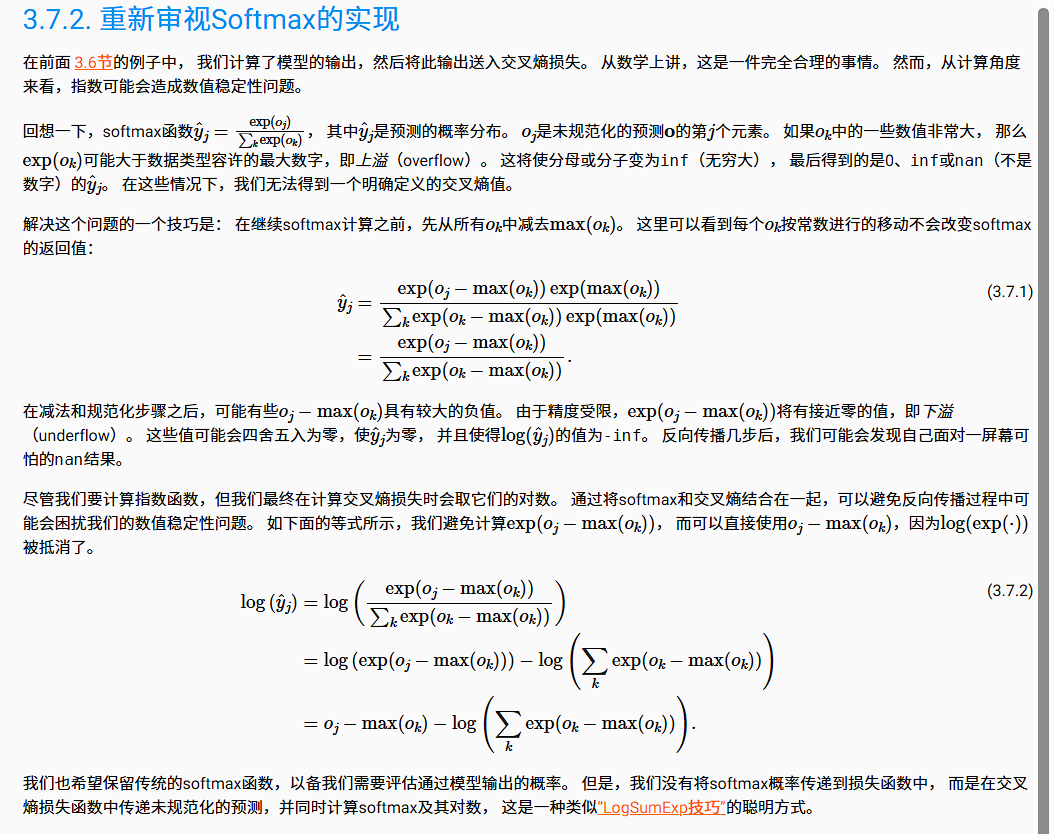

In [537]:
loss = nn.CrossEntropyLoss(reduction='none')

In [538]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [541]:
um_epochs = 10
train_ch3(net, train_loader, test_loader, loss, num_epochs, trainer)

训练损失:0.6665439196268718,训练精度:0.7659333333333334
eval精度:0.8004
训练损失:0.4937337611516317,训练精度:0.82545
eval精度:0.8204
训练损失:0.4678083073933919,训练精度:0.83645
eval精度:0.8253
训练损失:0.4519819585800171,训练精度:0.8422333333333333
eval精度:0.8196
训练损失:0.4460495709101359,训练精度:0.84405
eval精度:0.8332
训练损失:0.4344997908274333,训练精度:0.8479166666666667
eval精度:0.7696
训练损失:0.4367083258946737,训练精度:0.8471166666666666
eval精度:0.8227
训练损失:0.42736220734914143,训练精度:0.8507166666666667
eval精度:0.8341
训练损失:0.42386353470484417,训练精度:0.8503166666666667
eval精度:0.8337
训练损失:0.42406110719045004,训练精度:0.8526666666666667
eval精度:0.8262


## 实验1 实验开始

In [ ]:
import numpy
import pandas as pd
import csv
import random
# from feature import Bag,Gram # 自定义两种特征提取算法

# sep = '\t' 以\t 作为分隔符
test_data=pd.read_csv(r"D:/OneDrive/桌面/机器学习/sentiment-analysis-on-movie-reviews句子情感分类数据集/test.tsv/test.tsv",sep = '\t',on_bad_lines='skip')
train_data=pd.read_csv(r"D:/OneDrive/桌面/机器学习/sentiment-analysis-on-movie-reviews句子情感分类数据集/train.tsv/train.tsv",sep = '\t',on_bad_lines='skip')

train_data
test_data

In [ ]:
# 特征提取

from sklearn.model_selection import train_test_split
train_label=train_data['Sentiment']
train_data= train_data[['PhraseId','SentenceId','Phrase']]

# 使用train_test_split进行数据划分  (只要数据的前1000条)
train_data=train_data[:20000]
train_label=train_label[:20000]
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.3, random_state=22)
x_train
x_test.shape # 300 rows × 4 columns

In [ ]:
#  """Bag of words"""
class Bag:
    def __init__(self,data):
        self.data=data
        self.dict_words=dict()  # 单词到单词编号的映射
        self.len=0 # 记录有几个单词
        self.train = x_train
        self.test= x_test
        self.train_label = [int(term) for term in y_train]  # 训练集类别
        self.test_label = [int(term) for term in y_test]  # 测试集类别
        self.train_matrix = None  # 训练集的0-1矩阵（每行一个句子）
        self.test_matrix = None  # 测试集的0-1矩阵（每行一个句子）
        # print(self.data.shape)
        # print(len(self.train_label))
        # print(len(self.test_label))
        # 1000 * 3
        
    def get_words(self):    
        for term in self.data['Phrase']:
            phrase = term.upper()   # 记得要全部转化为大写！！（或者全部小写，否则一个单词例如i，I会识别成不同的两个单词）
            phrase_list=phrase.split()
            # print(phrase_list)  # 每一句都是一个列表
            for phrase in phrase_list:
               if phrase not in self.dict_words: # 语料库
                   # print(phrase)
                   self.dict_words[phrase]=len(self.dict_words)  
        self.len=len(self.dict_words) # 语料库大小
        self.test_matrix = numpy.zeros((len(self.test), self.len))  # 初始化0-1矩阵
        self.train_matrix = numpy.zeros((len(self.train), self.len))  # 初始化0-1矩阵
        # print(self.train_matrix.shape) # (1000, 363) 1000个句子  363个语料库单词
    # 将文本转为数据
    def get_matrix(self):
        for i in range(len(self.train)):
            phrase=self.train.iloc[i][2].upper()
            phrase_list=phrase.split()
            for phrase in phrase_list:
                self.train_matrix[i][self.dict_words[phrase]]=1
        for i in range(len(self.test)):
            phrase=self.test.iloc[i][2].upper()
            phrase_list=phrase.split()
            for phrase in phrase_list:
                self.test_matrix[i][self.dict_words[phrase]]=1
        # print(self.test_matrix.shape)       # (300, 363)
        # print(pd.DataFrame(self.test_matrix))

In [ ]:
# 特征提取
bag=Bag(train_data)
bag.get_words()
test_matrix=bag.get_matrix()


In [ ]:
#  """N-gram"""
class Gram:
    def __init__(self,data,dimension):
        self.data=data
        self.dict_words=dict()  #  特征到t正编号的映射
        self.len=0 # 语料库大小
        self.dimension = dimension  # 决定使用几元特征
        self.train = x_train
        self.test= x_test
        self.train_label = [int(term) for term in y_train]  # 训练集类别
        self.test_label = [int(term) for term in y_test]  # 测试集类别
        self.train_matrix = None  # 训练集的0-1矩阵（每行一个句子）
        self.test_matrix = None  # 测试集的0-1矩阵（每行一个句子）

    # 构造语料库
    def get_words(self):
         for d in range(1,self.dimension+1):# 提取 1-gram, 2-gram,..., N-gram 特征
             for term in self.data['Phrase']:
                 phrase=term.upper()
                 phrase_list=phrase.split()
                 for i in range(len(phrase_list)-d+1):
                     temp=phrase_list[i:i+d] # 相邻的N个单词 组成一组
                     temp="_".join(temp)  # 构成ESCAPADES_DEMONSTRATING 的形式
                     if temp not in self.dict_words:
                         self.dict_words[temp] = len(self.dict_words)
         self.len=len(self.dict_words)
         self.test_matrix = numpy.zeros((len(self.test), self.len))  # 训练集矩阵初始化
         self.train_matrix = numpy.zeros((len(self.train), self.len))  # 测试集矩阵初始化
         # print(self.dict_words)
    def get_matrix(self):
         for d in range(1,self.dimension+1):# 提取 1-gram, 2-gram,..., N-gram 特征
             for i in range(len(self.train)):
                phrase=self.train.iloc[i][2].upper()
                phrase_list=phrase.split()
                for j in range(len(phrase_list)-d+1):
                    temp = phrase_list[j:j + d]
                    temp = "_".join(temp)
                    # print(temp,self.dict_words[temp])
                    self.train_matrix[i][self.dict_words[temp]] = 1
         # print(pd.DataFrame(self.train_matrix))
         for  i in range(len(self.test)):  # 测试集矩阵
                phrase = self.test.iloc[i][2].upper()
                phrase_list = phrase.split()
                for j in range(len(phrase_list) - d + 1):
                    temp = phrase_list[j:j + d]
                    temp = "_".join(temp)
                    self.test_matrix[i][self.dict_words[temp]] = 1

         # print(pd.DataFrame(self.test_matrix))

In [ ]:
# 演示核心步骤
for d in range(2,2+1):
    print(d)
    for term in train_data['Phrase']:
        phrase=term.upper()
        phrase_list=phrase.split()
        print(phrase_list)
        for i in range(len(phrase_list)-2+1):
            temp=phrase_list[i:i+2]
            
            temp="_".join(temp)
            print(temp)
        print("*************************************")

In [ ]:
gram=Gram(train_data, dimension=2)
gram.get_words()
gram.get_matrix()

In [ ]:
## softmax回归 (神经网络 更新权重系数W 梯度下降)
class Softmax:
    def __init__(self,sample,typenum,feature):
        self.sample = sample  # 训练集样本个数
        self.typenum = typenum  # （情感）种类个数
        self.feature = feature  # 0-1向量的长度
        self.W = numpy.random.randn(feature, typenum)  # 参数矩阵W初始化

    def softmax_calculation(self,x):
        # x是 原始数据 （将其变为非负 且和为1的数据）
        exp = numpy.exp(x - numpy.max(x))  # 先减去最大值防止指数太大溢出
        return exp / exp.sum()

    def softmax_all(self, wtx):
        """wtx是矩阵，即许多向量叠在一起，按行计算softmax值"""
        wtx -= numpy.max(wtx, axis=1, keepdims=True) # 先减去行最大值防止指数太大溢出
        wtx = numpy.exp(wtx)
        wtx /= numpy.sum(wtx, axis=1, keepdims=True)
        return wtx

    
    def change_y(self, y):
        """把（情感）种类转换为一个one-hot向量  目的是与输出不同类别的概率形式相符合"""
        ans = numpy.array([0] * self.typenum)
        ans[y] = 1
        return ans.reshape(-1, 1)

    def prediction(self, X):
        """给定0-1矩阵X，计算每个句子的y_hat 值（概率）"""
        # 计算 原数据 点乘 权重矩阵 之后的概率（预测概率）
        # 注意 权重矩阵  是不断更新的 因此y_hat也是不断变化的  
        # y_hat 在变化过程中 会反馈损失函数 根据损失值又可以动态更新W矩阵 进而得出更好的y_hat
        prob = self.softmax_all(X.dot(self.W))
        return prob.argmax(axis=1)  # 输出预测类别的标签值
        
    def correct_rate(self, train_x, train_y, test_x, test_y):
        """计算训练集和测试集的准确率"""
        # train set
        n_train = len(train_x)
        pred_train = self.prediction(train_x)
        train_correct = sum([train_y[i] == pred_train[i] for i in range(n_train)]) / n_train
        # test set
        n_test = len(test_x)
        pred_test = self.prediction(test_x)
        test_correct = sum([test_y[i] == pred_test[i] for i in range(n_test)]) / n_test
        
        return train_correct, test_correct

    # alpha 学习率
    def regression(self, X, y, alpha, times, strategy="mini"):
        """Softmax regression"""
        if self.sample != len(X) or self.sample != len(y):
            raise Exception("Sample size does not match!")  # 样本个数不匹配
        if strategy == "mini":  # mini-batch
            mini_size=1000 # 每次随机抽100个样本
            for i in range(times): # epoch
                increment = numpy.zeros((self.feature, self.typenum))  # 梯度初始为0矩阵
                for j in range(mini_size):  # 随机抽K次
                    k = random.randint(0, self.sample - 1) 
                    yhat = self.softmax_calculation(self.W.T.dot(X[k].reshape(-1, 1)))
                    increment += X[k].reshape(-1, 1).dot((self.change_y(y[k]) - yhat).T)  # 梯度加和
                # print(i * mini_size)
                self.W += alpha / mini_size * increment  # 参数更新
        elif strategy == "shuffle":  # 随机梯度
            for i in range(times): 
                k = random.randint(0, self.sample - 1)  # 每次抽一个
                yhat = self.softmax_calculation(self.W.T.dot(X[k].reshape(-1, 1)))
                increment = X[k].reshape(-1, 1).dot((self.change_y(y[k]) - yhat).T)  # 计算梯度
                self.W += alpha * increment  # 参数更新
                # if not (i % 10000):
                #     print(i)
        elif strategy=="batch":  # 整批量梯度
            for i in range(times):
                increment = numpy.zeros((self.feature, self.typenum))  ## 梯度初始为0矩阵
                for j in range(self.sample):  # 所有样本都要计算
                    yhat = self.softmax_calculation(self.W.T.dot(X[j].reshape(-1, 1)))
                    increment += X[j].reshape(-1, 1).dot((self.change_y(y[j]) - yhat).T)  # 梯度加和
                # print(i)
                self.W += alpha / self.sample * increment  # 参数更新
        else:
            raise Exception("Unknown strategy")

In [287]:
# ------------------------------ Bag特征实验 ------------------------------
# Shuffle策略（Bag特征）
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
shuffle_train_bag = []
shuffle_test_bag = []
total_times = 200000 # 总轮数

for alpha in alphas:
    soft = Softmax(len(bag.train), 5, bag.len)
    soft.regression(bag.train_matrix, bag.train_label, alpha, times=total_times, strategy="shuffle")
    r_train, r_test = soft.correct_rate(bag.train_matrix, bag.train_label, bag.test_matrix, bag.test_label)
    shuffle_train_bag.append(r_train)
    shuffle_test_bag.append(r_test)
    print(f"[Bag-Shuffle] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")

# Batch策略（Bag特征）
batch_train_bag = []
batch_test_bag = []
for alpha in alphas:
    soft = Softmax(len(bag.train), 5, bag.len)
    soft.regression(bag.train_matrix, bag.train_label, alpha, int(total_times/20000), strategy="batch")
    r_train, r_test = soft.correct_rate(bag.train_matrix, bag.train_label, bag.test_matrix, bag.test_label)
    batch_train_bag.append(r_train)
    batch_test_bag.append(r_test)
    print(f"[Bag-Batch] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")

# Mini-batch策略（Bag特征）
mini_train_bag = []
mini_test_bag = []
mini_size = 1000
for alpha in alphas:
    soft = Softmax(len(bag.train), 5, bag.len)
    soft.regression(bag.train_matrix, bag.train_label, alpha, int(total_times/mini_size), strategy="mini")
    r_train, r_test = soft.correct_rate(bag.train_matrix, bag.train_label, bag.test_matrix, bag.test_label)
    mini_train_bag.append(r_train)
    mini_test_bag.append(r_test)
    print(f"[Bag-MiniBatch] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")


# ------------------------------ Gram特征实验 ------------------------------
# Shuffle策略（Gram特征）
shuffle_train_gram = []
shuffle_test_gram = []
for alpha in alphas:
    soft = Softmax(len(gram.train), 5, gram.len)
    soft.regression(gram.train_matrix, gram.train_label, alpha, times=total_times, strategy="shuffle")
    r_train, r_test = soft.correct_rate(gram.train_matrix, gram.train_label, gram.test_matrix, gram.test_label)
    shuffle_train_gram.append(r_train)
    shuffle_test_gram.append(r_test)
    print(f"[Gram-Shuffle] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")

# Batch策略（Gram特征）
batch_train_gram = []
batch_test_gram = []
for alpha in alphas:
    soft = Softmax(len(gram.train), 5, gram.len)
    soft.regression(gram.train_matrix, gram.train_label, alpha, int(total_times/20000), strategy="batch")
    r_train, r_test = soft.correct_rate(gram.train_matrix, gram.train_label, gram.test_matrix, gram.test_label)
    batch_train_gram.append(r_train)
    batch_test_gram.append(r_test)
    print(f"[Gram-Batch] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")

# Mini-batch策略（Gram特征）
mini_train_gram = []
mini_test_gram = []
for alpha in alphas:
    soft = Softmax(len(gram.train), 5, gram.len)
    soft.regression(gram.train_matrix, gram.train_label, alpha, int(total_times/mini_size), strategy="mini")
    r_train, r_test = soft.correct_rate(gram.train_matrix, gram.train_label, gram.test_matrix, gram.test_label)
    mini_train_gram.append(r_train)
    mini_test_gram.append(r_test)
    print(f"[Gram-MiniBatch] 学习率：{alpha}，训练集准确率：{r_train:.4f}，验证集准确率：{r_test:.4f}")

[Bag-Shuffle] 学习率：0.001，训练集准确率：0.2848，验证集准确率：0.2767
[Bag-Shuffle] 学习率：0.01，训练集准确率：0.4392，验证集准确率：0.3667
[Bag-Shuffle] 学习率：0.1，训练集准确率：0.6967，验证集准确率：0.4852
[Bag-Shuffle] 学习率：1，训练集准确率：0.6789，验证集准确率：0.4642
[Bag-Shuffle] 学习率：10，训练集准确率：0.6708，验证集准确率：0.4740
[Bag-Shuffle] 学习率：100，训练集准确率：0.6646，验证集准确率：0.4740
[Bag-Shuffle] 学习率：1000，训练集准确率：0.6743，验证集准确率：0.4905
[Bag-Shuffle] 学习率：10000，训练集准确率：0.6926，验证集准确率：0.4970
[Bag-Batch] 学习率：0.001，训练集准确率：0.2055，验证集准确率：0.2103
[Bag-Batch] 学习率：0.01，训练集准确率：0.1778，验证集准确率：0.1815
[Bag-Batch] 学习率：0.1，训练集准确率：0.2063，验证集准确率：0.2033
[Bag-Batch] 学习率：1，训练集准确率：0.2191，验证集准确率：0.2225
[Bag-Batch] 学习率：10，训练集准确率：0.2584，验证集准确率：0.2447
[Bag-Batch] 学习率：100，训练集准确率：0.2183，验证集准确率：0.1987
[Bag-Batch] 学习率：1000，训练集准确率：0.4222，验证集准确率：0.3583
[Bag-Batch] 学习率：10000，训练集准确率：0.4262，验证集准确率：0.3608
[Bag-MiniBatch] 学习率：0.001，训练集准确率：0.1888，验证集准确率：0.1923
[Bag-MiniBatch] 学习率：0.01，训练集准确率：0.2323，验证集准确率：0.2202
[Bag-MiniBatch] 学习率：0.1，训练集准确率：0.2254，验证集准确率：0.2248
[Bag-MiniBatch] 学习率：1，训练集准确率：0.2918，验证集准确率：0.2753
[

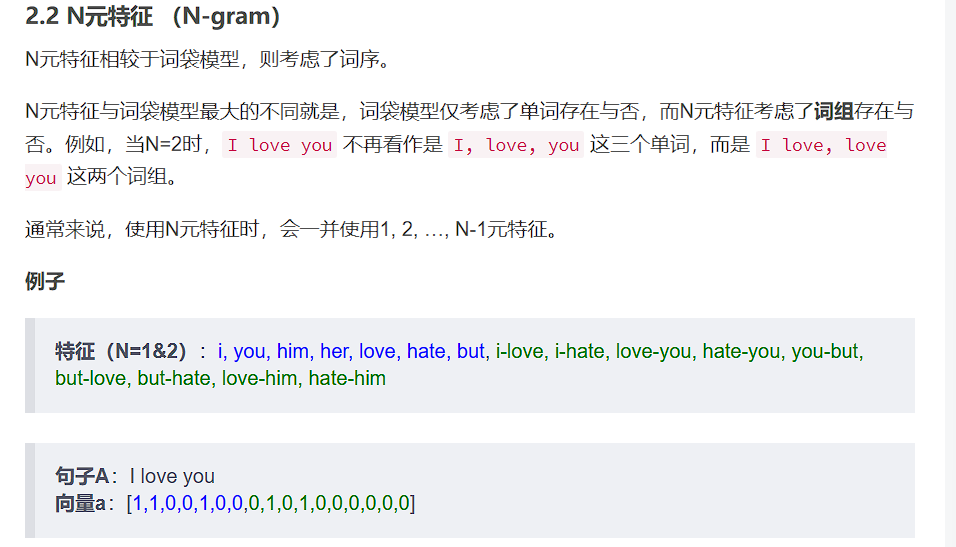

###  绘图比较

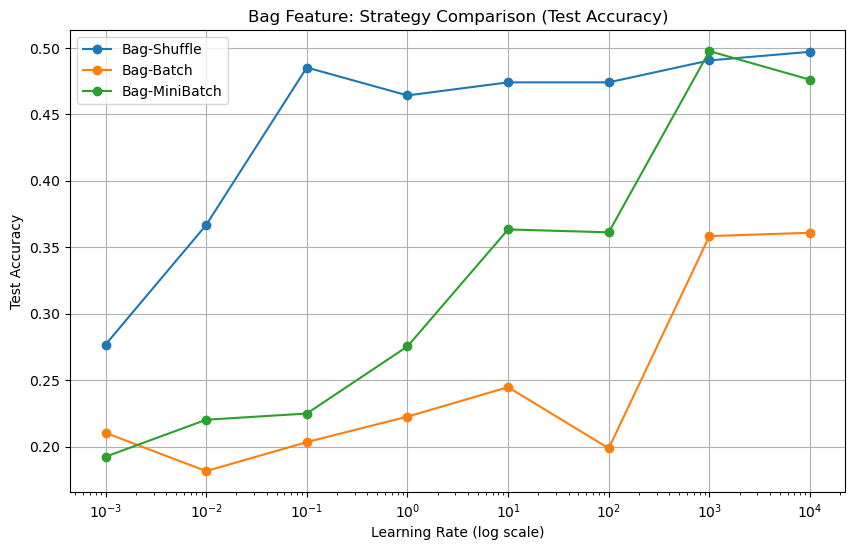

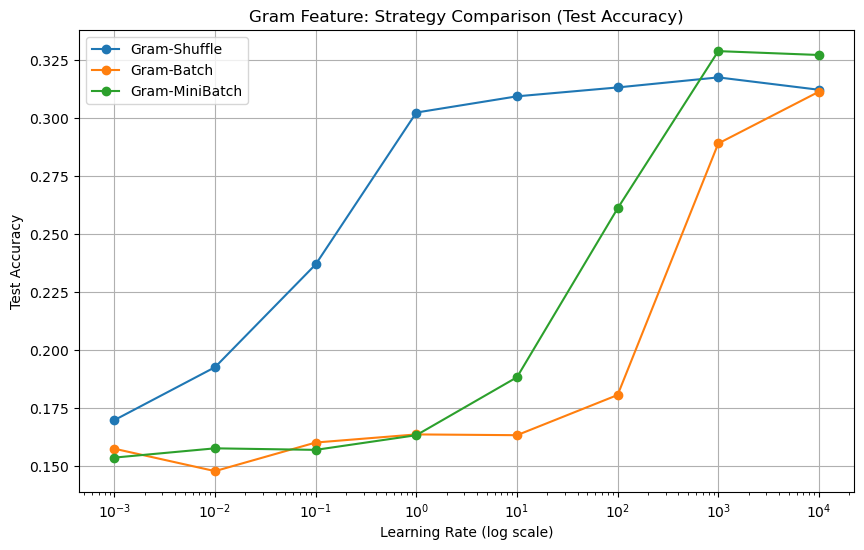

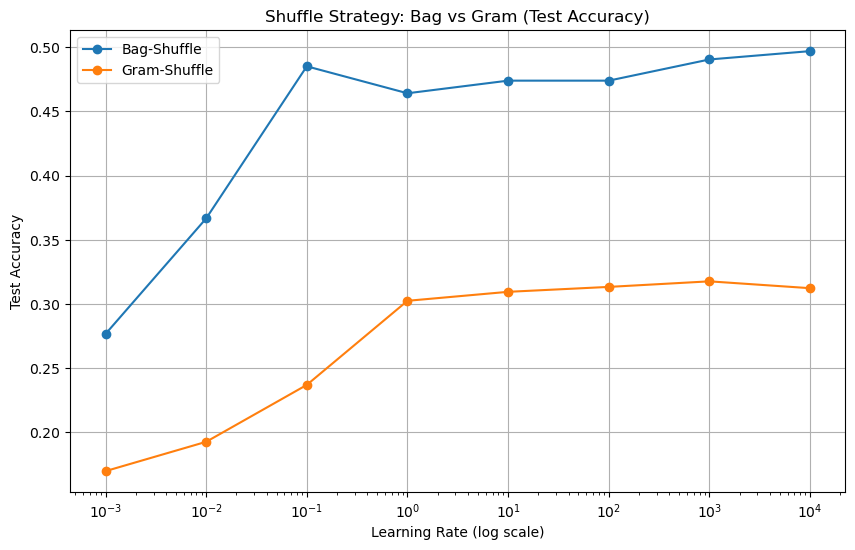

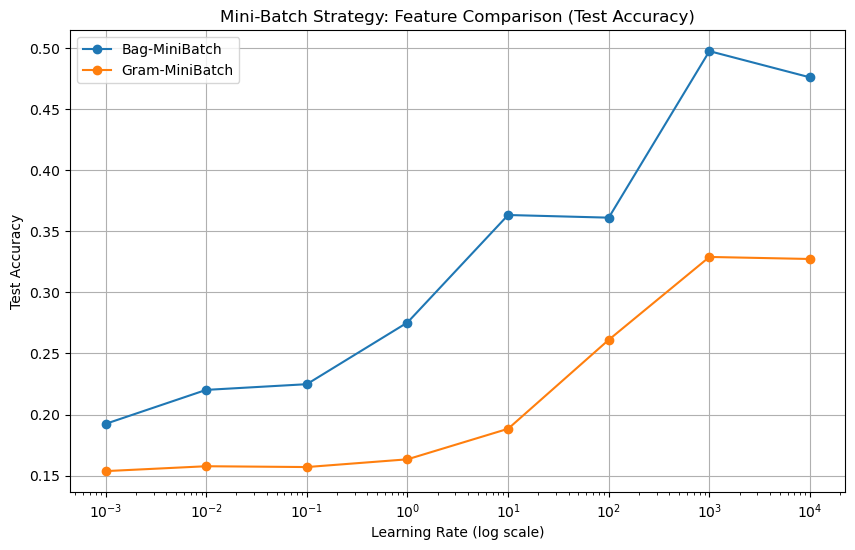

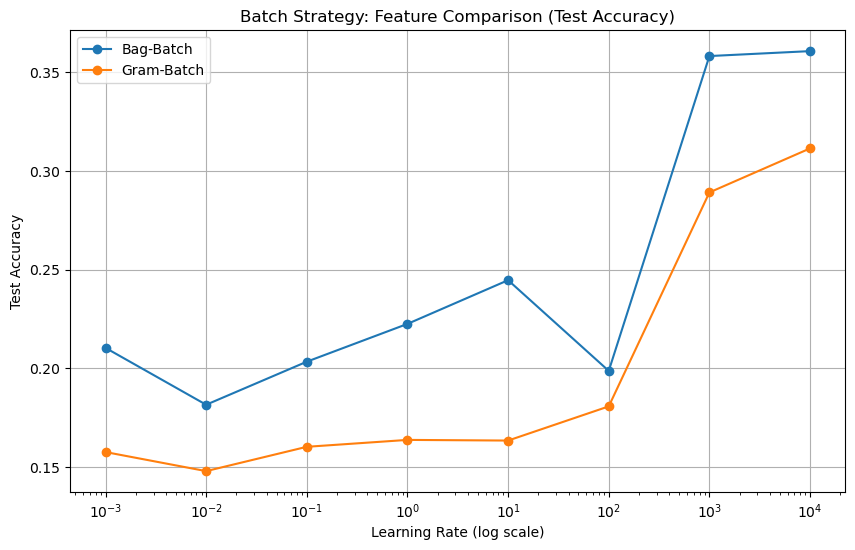

In [288]:
import matplotlib.pyplot as plt

# 定义学习率列表
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

# 定义绘图函数 （ ）
def plot_comparison(alphas, data_dict, title, log_x=True):
    plt.figure(figsize=(10, 6))
    if log_x:
        plt.xscale('log')
    for label, (train_acc, test_acc) in data_dict.items():
        plt.plot(alphas, test_acc, label=label, marker='o')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Test Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# 比较不同策略在Bag特征下的表现
bag_strategies = {
    'Bag-Shuffle': (shuffle_train_bag, shuffle_test_bag),
    'Bag-Batch': (batch_train_bag, batch_test_bag),
    'Bag-MiniBatch': (mini_train_bag, mini_test_bag)
}
plot_comparison(alphas, bag_strategies, 'Bag Feature: Strategy Comparison (Test Accuracy)')

# 比较不同策略在Gram特征下的表现
gram_strategies = {
    'Gram-Shuffle': (shuffle_train_gram, shuffle_test_gram),
    'Gram-Batch': (batch_train_gram, batch_test_gram),
    'Gram-MiniBatch': (mini_train_gram, mini_test_gram)
}
plot_comparison(alphas, gram_strategies, 'Gram Feature: Strategy Comparison (Test Accuracy)')

# 比较不同特征在相同策略下的表现（以Shuffle为例）
shuffle_features = {
    'Bag-Shuffle': (shuffle_train_bag, shuffle_test_bag),
    'Gram-Shuffle': (shuffle_train_gram, shuffle_test_gram)
}
plot_comparison(alphas, shuffle_features, 'Shuffle Strategy: Bag vs Gram (Test Accuracy)')

# 比较学习率对同一策略的影响（以Mini-batch为例）
mini_features = {
    'Bag-MiniBatch': (mini_train_bag, mini_test_bag),
    'Gram-MiniBatch': (mini_train_gram, mini_test_gram)
}
plot_comparison(alphas, mini_features, 'Mini-Batch Strategy: Feature Comparison (Test Accuracy)')

# 比较学习率对同一策略的影响（以Batch为例）
batch_features = {
    'Bag-Batch': (batch_train_bag, batch_test_bag),
    'Gram-Batch': (batch_train_gram,batch_test_gram)
}
plot_comparison(alphas, batch_features, 'Batch Strategy: Feature Comparison (Test Accuracy)')



对于上述实验， 在后续实验过程中 待改进的地方：
- 数据量小（20000）
- 小批量数据中，不同的mini_batch会有不同的效果
- 交叉熵的计算：
 
  Softmax类中的`regression`方法负责参数的更新。在每次迭代中，计算了`yhat`（预测概率）和`self.change_y(y[k])`（真实标签的one-hot编码），然后通过两者的差异（`self.change_y(y[k]) - yhat`）来调整梯度`increment`。这一步骤实际上是在计算交叉熵损失的梯度，因为交叉熵损失对权重的导数就涉及到预测概率和真实标签的差异。
-  计算梯度：真实标签的 one-hot 向量与预测概率的差
increment = X[k].reshape(-1, 1).dot((self.change_y(y[k]) - yhat).T)

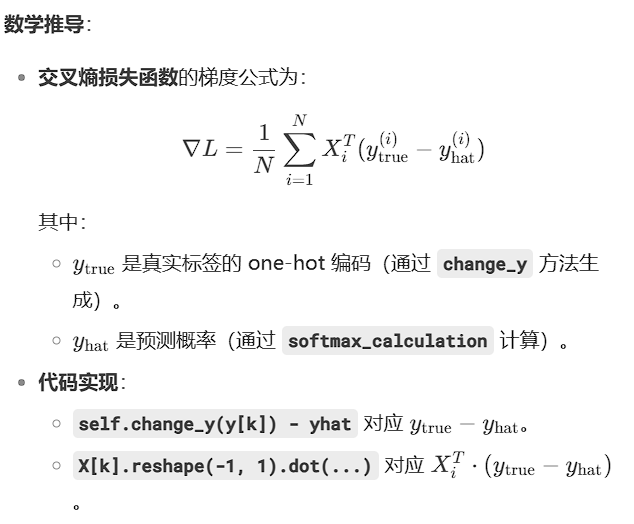

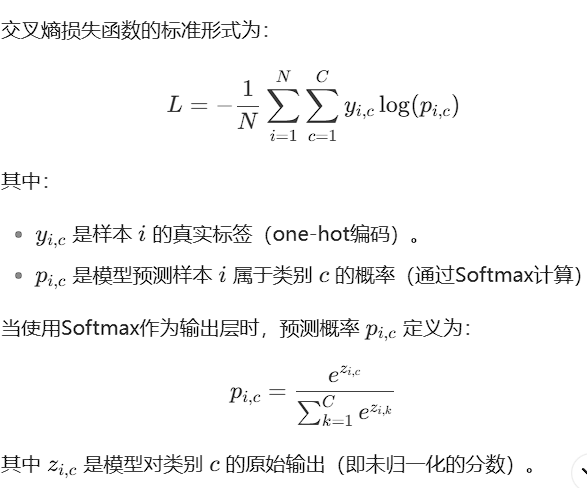

在进行梯度求解过程中，在梯度公式中，log项被消去，最终梯度仅依赖于真实标签与预测概率的差。

在代码中无需显式计算log值，直接通过预测概率和真实标签的差异即可更新参数。

softmax回归 交叉熵损失函数的 梯度求解过程

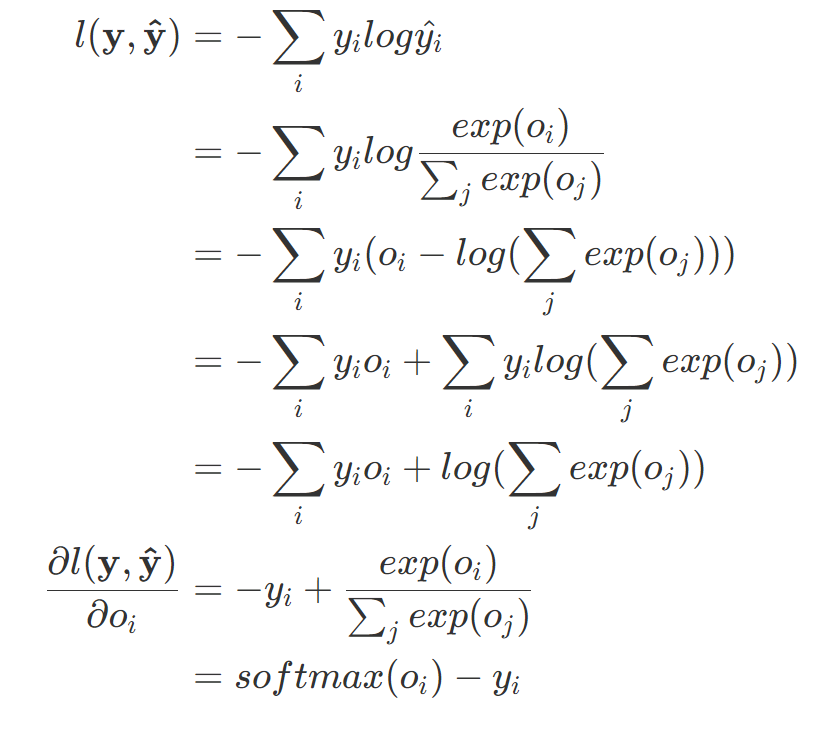